## 一、背景

手游在当下的日常娱乐中占据着主导性地位，成为人们生活中放松身心的一种有效途径。近年来，各种类型的手游，尤其是闯关类的休闲手游，由于其对碎片化时间的利用取得了非常广泛的市场。然而在此类手游中，新用户流失是一个非常严峻的问题，有相当多的新用户在短暂尝试后会选择放弃，而如果能在用户还没有完全卸载游戏的时候针对流失可能性较大的用户施以干预（例如奖励道具、暖心短信），就可能挽回用户从而提升游戏的活跃度和公司的潜在收益，因此用户的流失预测成为一个重要且挑战性的问题。在毕业项目中我们将从真实游戏中非结构化的日志数据出发，构建用户流失预测模型，综合已有知识设计适合的算法解决实际问题。

## 二、任务

* 根据给出的实际数据（包括用户游玩历史，关卡特征等），预测测试集中的用户是否为流失用户（二分类）；
* 提交代码与实验报告，报告展示对数据的观察、分析、最后的解决方案以及不同尝试的对比等。

## 三、评价指标
AUC

## 四、数据概览

本次使用的是一个休闲类闯关手游的数据，用户在游戏中不断闯关，每一关的基本任务是在限定步数内达到某个目标。每次闯关可能成功也可能失败，一般情况下用户只在完成一关后进入下一关，闯关过程中可以使用道具或提示等帮助。

对大多数手游来说，用户流失往往发生在早期，因此次周的留存情况是公司关注的一个重点。本次数据选取了 2020.2.1 注册的所有用户在 2.1-2.4 的交互数据，数据经过筛选保证这些注册用户在前四日至少有两日登录。流失的定义则参照次周（2.7-2.13）的登录情况，如果没有登录为流失。

本次的数据和以往结构化的形式不同，展现的是更原始的数据记录，更接近公司实际日志的形式，共包含 5 个文件：

### train.csv

训练集用户，包括用户 id（从 1 开始）以及对应是否为流失用户的 label（1：流失，0：留存）。

In [571]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('./data/train.csv', sep='\t')
train_df.T

,0,1,2,3,4,5,6,7,8,9,...,8148,8149,8150,8151,8152,8153,8154,8155,8156,8157
user_id,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,...,10922,10923,10924,10925,10926,10927,10928,10929,10930,10931
label,0,0,1,0,1,1,0,0,0,1,...,0,0,0,1,1,1,1,0,1,0


In [572]:
train_df['label'].value_counts()

0    5428
1    2730
Name: label, dtype: int64

训练集共 8158 个用户，其中流失用户大约占 1/3，需要注意的是为了匿名化，这里数据都经过一定的非均匀抽样处理，流失率并不反映实际游戏的情况，用户与关卡的 id 同样经过了重编号，但对于流失预测任务来说并没有影响。

### dev.csv

验证集格式和训练集相同，主要为了方便离线测试与模型选择。

In [573]:
dev_df = pd.read_csv('./data/dev.csv', sep='\t')
dev_df.T

,0,1,2,3,4,5,6,7,8,9,...,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657
user_id,10932,10933,10934,10935,10936,10937,10938,10939,10940,10941,...,13580,13581,13582,13583,13584,13585,13586,13587,13588,13589
label,0,1,0,1,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,1,0


### test.csv
测试集只包含用户 id，任务就是要预测这些用户的流失概率。

In [574]:
test_df = pd.read_csv('./data/test.csv', sep='\t')
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772
user_id,1,2,3,4,5,6,7,8,9,10,...,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773


### level_seq.csv
这个是核心的数据文件，包含用户游玩每个关卡的记录，每一条记录是对某个关卡的一次尝试，具体每列的含义如下：

* `user_id`：用户 id，和训练、验证、测试集中的可以匹配；
* `level_id`：关卡 id；
* `f_success`：是否通关（1：通关，0：失败）；
* `f_duration`：此次尝试所用的时间（单位 s）；
* `f_reststep`：剩余步数与限定步数之比（失败为 0）；
* `f_help`：是否使用了道具、提示等额外帮助（1：使用，0：未使用）；
* `time`：时间戳。

In [575]:
seq_df = pd.read_csv('./data/level_seq.csv', sep='\t')
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12
...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40


### level_meta.csv
每个关卡的一些统计特征，可用于表示关卡，具体每列的含义如下：

* `f_avg_duration`：平均每次尝试花费的时间（单位 s，包含成功与失败的尝试）；
* `f_avg_passrate`：平均通关率；
* `f_avg_win_duration`：平均每次通关花费的时间（单位 s，只包含通关的尝试）；
* `f_avg_retrytimes`：平均重试次数（第二次玩同一关算第 1 次重试）；
* `level_id`：关卡 id，可以和 level_seq.csv 中的关卡匹配。

In [576]:
meta_df = pd.read_csv('./data/level_meta.csv', sep='\t')
meta_df

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.889940,0.944467,35.582757,0.017225,1
1,60.683975,0.991836,56.715706,0.004638,2
2,76.947355,0.991232,71.789943,0.004480,3
3,58.170347,0.993843,54.842882,0.004761,4
4,101.784577,0.954170,85.650547,0.027353,5
...,...,...,...,...,...
1504,594.878788,0.453730,133.625000,3.187500,1505
1505,486.562500,0.454180,115.906250,3.218750,1506
1506,325.968750,0.573525,86.250000,2.687500,1507
1507,793.096774,0.322684,164.000000,5.419355,1508


## 五、特征工程

总体思路：根据游玩关卡的记录为每个用户提取特征 → 结合 label 构建表格式的数据集 → 使用不同模型训练与测试；

In [577]:
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import seaborn as sns

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score,roc_curve, auc, accuracy_score
from pandas_profiling import ProfileReport

### 5.1特征构造
按用户重游玩每个关卡的记录，构数据集为每个用户为一个样本，提取以下特征： 
* user_win_rate_tail：用户最后5%场次的胜率
* user_level_skill：用户技能
* user_active：用户活跃度
* user_help:用户使用帮助次数
* user_login_days:用户登录天数
* user_last_login:用户最后登录时间
* user_duration:用户总花费时间

In [578]:
# #     
# user_level_duration = seq_df.groupby(['user_id','level_id'])['f_duration'].agg([('user_level_duration','mean')]).reset_index()  

# # 用户在某关卡平均通关时间
# user_level_win_duration = seq_df.query('f_success ==1').groupby(['user_id','level_id'])['f_duration'].agg([('user_level_win_duration','mean')]).reset_index()

# # 用户在某关卡重试次数
# user_level_retrytimes = seq_df.groupby(['user_id','level_id'])['f_help'].agg([('user_level_retrytimes','count')]).reset_index() 

# # 用户在某关卡通关率
# user_level_passrate = seq_df.query('f_success ==0').groupby(['user_id','level_id'])['f_help'].agg([('user_level_passrate','count')]).reset_index()  
# user_level_passrate['user_level_passrate'] = user_level_passrate['user_level_passrate'].map(lambda p: 1/(p+1)) 


# 用户最后5%场次的胜率
user_win_rate_tail = (seq_df.sort_values(['user_id','time'], ascending=[True, False])
            .groupby('user_id', group_keys=False)
            .apply(lambda x: x.head(len(x)//5)))
user_win_rate_tail = user_win_rate_tail.groupby('user_id')['f_success'].apply(lambda x: -x.sum()/x.count()) .reset_index()   
user_win_rate_tail = user_win_rate_tail.rename({'f_success':'user_win_rate_tail'},axis='columns')

# 用户技能/熟练度：取通关时的剩余步数与限定步数之比
user_level_skill = seq_df.query('f_success ==1').groupby(['user_id'])['f_reststep'].agg([('user_level_skill','mean')]).reset_index()  

# 用户活跃度：取总场次
user_active = seq_df.groupby(['user_id'])['f_reststep'].agg([('user_active','count')]).reset_index()  

# 用户使用帮助次数
user_help = seq_df.groupby('user_id')['f_help'].agg([('user_help','sum')]).reset_index()  

# 用户登录天数
user_login_days = seq_df[['user_id','time']].copy()
user_login_days['day']=user_login_days['time'].map(lambda t: t[8:10])
user_login_days = user_login_days.drop(columns='time')
user_login_days = user_login_days.drop_duplicates()
user_login_days = user_login_days.groupby(['user_id'])['day'].agg([('user_login_days','count')]).reset_index() 

# 用户最后登录时间
user_last_login = seq_df.groupby(['user_id'])['time'].agg([('user_last_login','max')]).reset_index() 
user_last_login['user_last_login'] = user_last_login['user_last_login'].map(lambda l: 
    (datetime.datetime.strptime('2020-02-05 00:00:00','%Y-%m-%d %H:%M:%S')-datetime.datetime.strptime(l,'%Y-%m-%d %H:%M:%S')).seconds)

# 用户总花费时间
user_duration = seq_df.groupby(['user_id'])['f_duration'].agg([('user_duration','sum')]).reset_index() 

# 把上面构造的用户、用户闯关信息的所有特征，全部合并起来
user_level_df = user_active.merge(user_win_rate_tail, on='user_id', how='left')
user_level_df = user_level_df.merge(user_level_skill, on='user_id', how='left')
user_level_df = user_level_df.merge(user_help, on='user_id', how='left')
user_level_df = user_level_df.merge(user_login_days, on='user_id', how='left')
user_level_df = user_level_df.merge(user_last_login, on='user_id', how='left')
user_level_df = user_level_df.merge(user_duration, on='user_id', how='left')

# 把上面构造的所有特征，再结合关卡特征
# user_level_df = user_level_df.merge(meta_df , on='level_id', how='left')

# # 构造特征：花费时间差（平均花费时间-用户在该关的花费时间）
# user_level_df['dif_duration']= user_level_df['f_avg_duration']-user_level_df['user_level_duration']

# # 构造特征：通关花费时间差（平均通关花费时间-用户在该关的通关花费时间）
# user_level_df['dif_win_duration']= user_level_df['f_avg_win_duration']-user_level_df['user_level_win_duration']

# # 构造特征：通关率差（平均每关通关花费的时间-用户在该关的通关率）
# user_level_df['dif_passrate']= user_level_df['f_avg_passrate']-user_level_df['user_level_passrate']

# 去除因为构造差值后的冗余特征
# user_level_df = user_level_df.drop(columns=['f_avg_duration','f_avg_win_duration','f_avg_passrate','user_level_duration','user_level_win_duration','user_level_passrate'])


### 5.2缺失数据处理

In [ ]:

# 对缺失值按0填充处理：
# user_level_df = user_level_df.fillna(0)
# user_level_df

#对缺失值按均值填充处理：
for col in list(user_level_df.columns[user_level_df.isnull().sum() > 0]):
    median_val = user_level_df[col].median()
    user_level_df[col].fillna(median_val, inplace=True)

### 5.3数据观测

In [579]:
#采用测试集的用户，关联上面构造的特征表，做数据观察
train_df_view = train_df.merge(user_level_df , on='user_id', how='left')
train_df_view

# profile = ProfileReport(train_df_view.drop(columns=['user_id']))
# profile.to_notebook_iframe()

,user_id,label,user_active,user_win_rate_tail,user_level_skill,user_help,user_login_days,user_last_login,user_duration
0,2774,0,215,-0.488372,0.265700,18,4,3257,25398.0
1,2775,0,111,-0.590909,0.305587,14,3,9370,18839.0
2,2776,1,69,-0.153846,0.292533,1,3,36087,6119.0
3,2777,0,286,-0.263158,0.245062,4,4,13054,40808.0
4,2778,1,162,-0.468750,0.324443,9,3,48137,32045.0
...,...,...,...,...,...,...,...,...,...
8153,10927,1,350,-0.285714,0.329179,10,4,10824,34697.0
8154,10928,1,50,-1.000000,0.471203,3,2,20549,4073.0
8155,10929,0,243,-0.333333,0.251438,14,3,12935,28858.0
8156,10930,1,39,-0.714286,0.400738,6,2,12842,6120.0


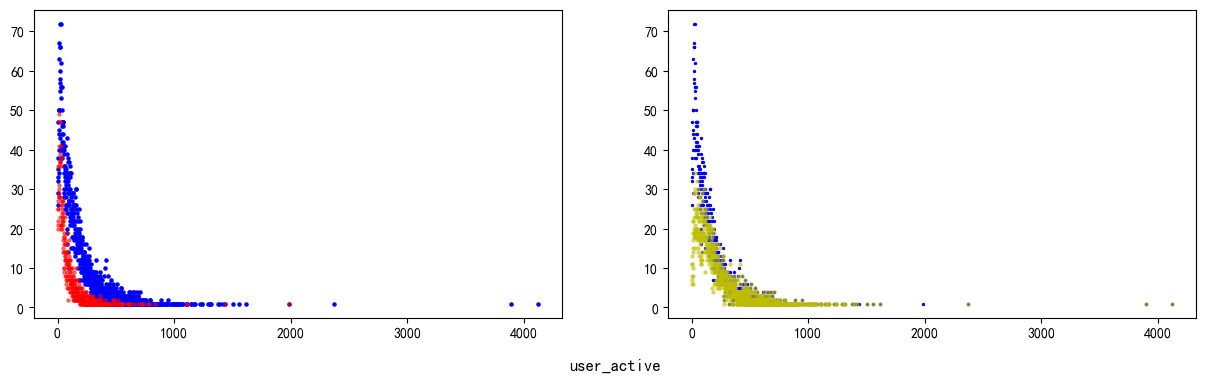

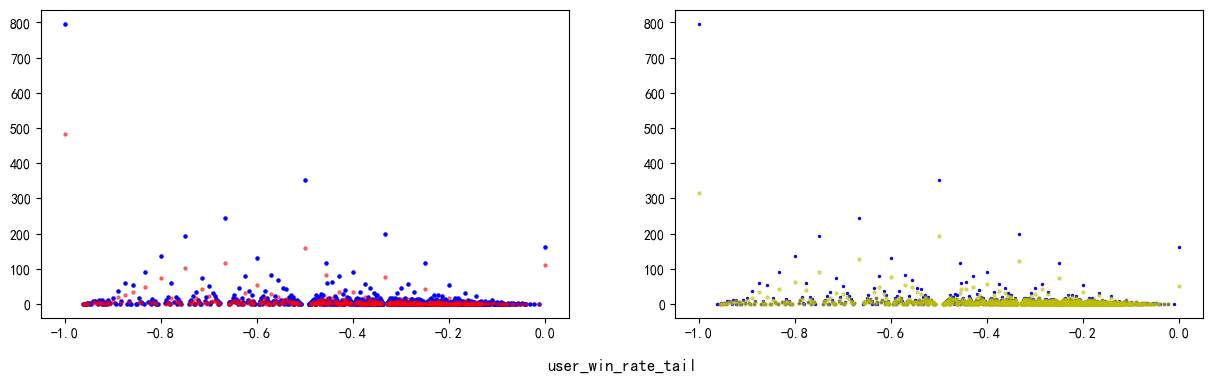

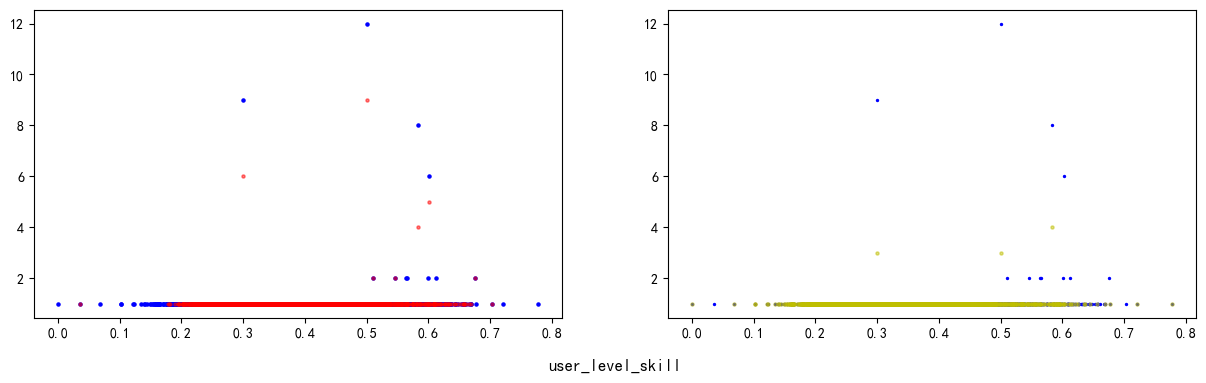

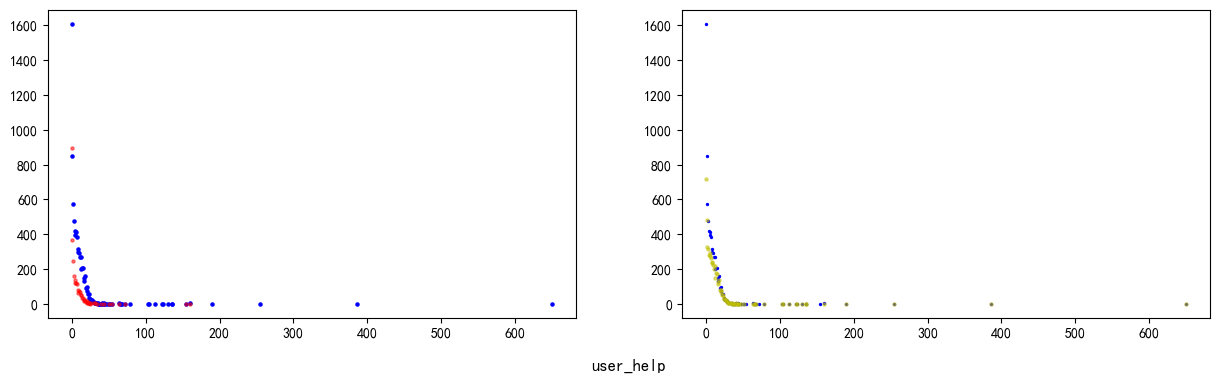

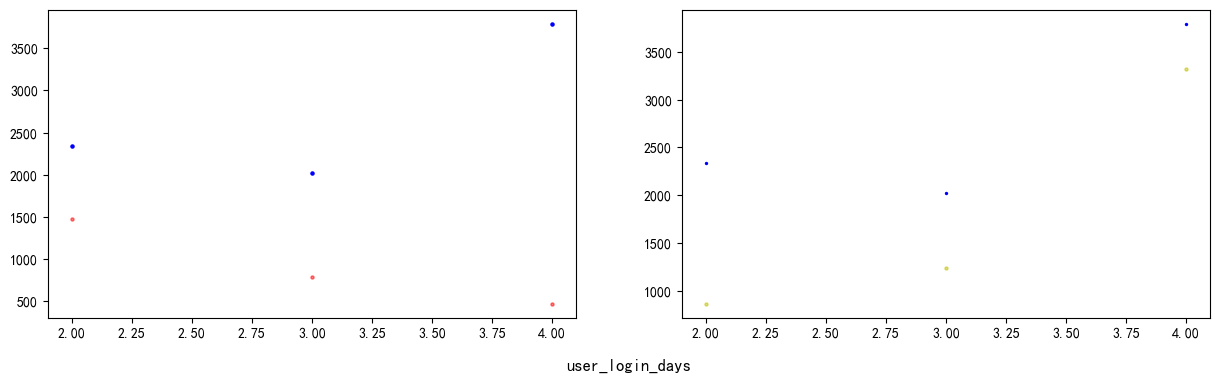

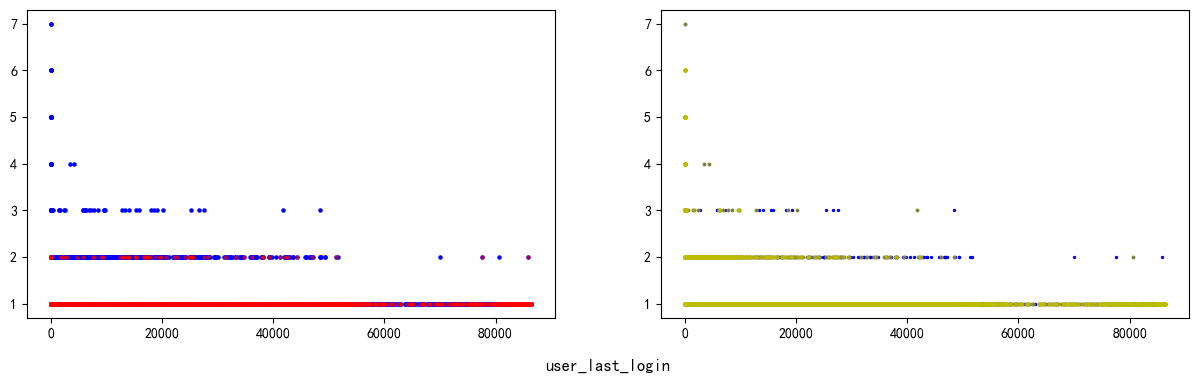

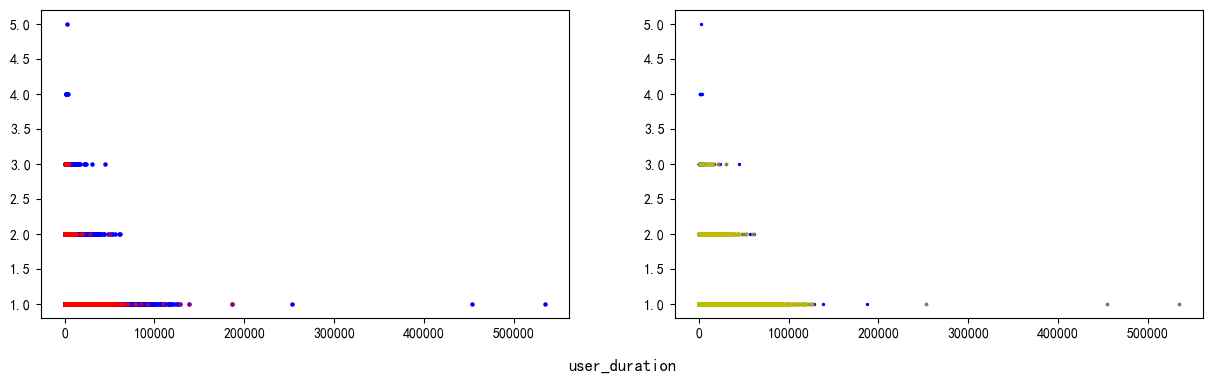

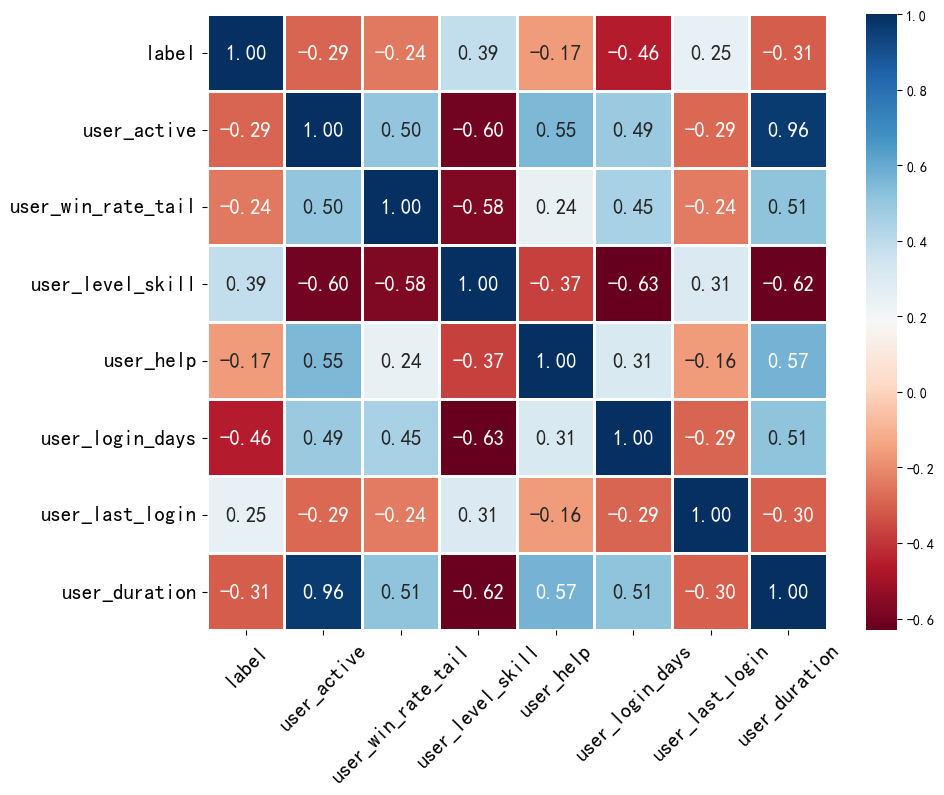

In [580]:
# train_df_view_1=train_df_view[train_df_view.label==1]
# train_df_view_0=train_df_view[train_df_view.label==0].sample(n=train_df_view_1.shape[0])
# train_df_view = pd.concat([train_df_view_1,train_df_view_0])
for col in train_df_view.columns:
    if col in ['user_id','label']:
        continue
    a = Counter(train_df_view[col])
    t = Counter(train_df_view[train_df_view['label'] == 1][col])
    f = Counter(train_df_view[train_df_view['label'] == 0][col])
    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    plt.rcParams['axes.unicode_minus'] = False
    plt.scatter(a.keys(), a.values(), s=5, c='b')
    plt.scatter(t.keys(), t.values(), alpha=0.5, s=5, c='r')
    plt.subplot(122)
    plt.scatter(a.keys(), a.values(), s=2, c='b')
    plt.scatter(f.keys(), f.values(), alpha=0.5, s=5, c='y')
    plt.title(col, x=-0.1, y=-0.2)
    plt.show()

    # a = Counter(train_df_view[col])
    # t = Counter(train_df_view[train_df_view['label'] == 1][col])
    # f = Counter(train_df_view[train_df_view['label'] == 0][col])
    # plt.figure(figsize=(10, 4))
    # plt.rcParams['axes.unicode_minus'] = False
    # plt.scatter(a.keys(), a.values(), s=3)
    # plt.scatter(t.keys(), t.values(), alpha=0.5, s=2)
    # plt.scatter(f.keys(), f.values(), alpha=0.5, s=2)
    # plt.title(col, y=-0.2)
    # plt.show()

plt.subplots(figsize=(10, 8))
plt.rcParams['axes.unicode_minus'] = False
plt.tick_params(labelsize=15)               # XY轴字体大小
sns.heatmap(train_df_view.drop(columns=['user_id']).corr(), cmap='RdBu', annot=True, fmt='0.2f',linewidths=2,annot_kws={'size':15})
plt.xticks(rotation=45)
plt.show()




### 5.4特征选择
用户登录频率高、花费时间较多的用户参与度高，较容易留存。最后场次的胜率比较关键，就算用户最后天登录，但边败的话，仍有较高流失率。另外，技能好的用户也容易流失。早期用户对帮助和道具还是有一定需求的。
用户活跃度与用户总花费时间具在强线性关联。用户活跃度的构造冗余，去除。

In [581]:
user_level_df =user_level_df.drop(columns=['user_active']).drop_duplicates()
user_level_df 

,user_id,user_win_rate_tail,user_level_skill,user_help,user_login_days,user_last_login,user_duration
0,1,-0.164557,0.210951,8,4,11270,38860.0
1,2,-0.234043,0.238137,20,4,6687,20190.0
2,3,-0.391304,0.311042,14,2,39573,22291.0
3,4,-0.285714,0.269842,8,4,61208,13234.0
4,5,-0.276596,0.265907,20,4,26823,29454.0
...,...,...,...,...,...,...,...
13584,13585,-0.122449,0.263517,12,3,2639,27237.0
13585,13586,-0.241935,0.242518,16,3,1965,38920.0
13586,13587,-0.250000,0.326847,0,2,29707,2195.0
13587,13588,-1.000000,0.424209,0,2,49424,2118.0


### 5.5数据再处理
在数据观测中，通过箱线图观测，用户技能、用户使用帮助次数和用户总花费时间存在明显离群数据。继续用箱型图判断异常点，把离群数据置为箱型图上下边缘值。

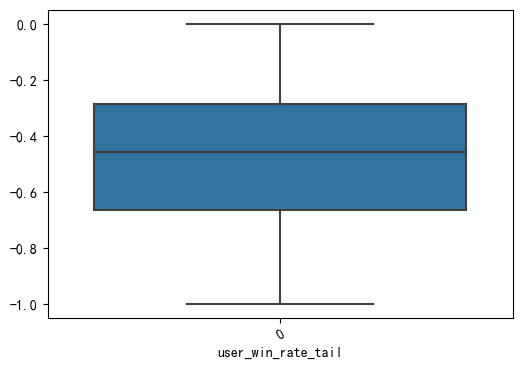

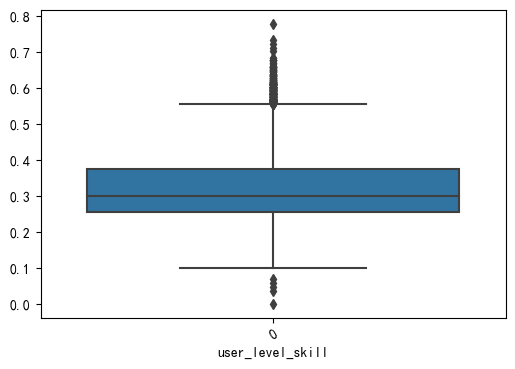

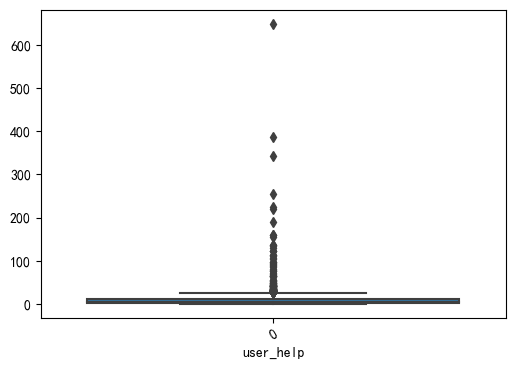

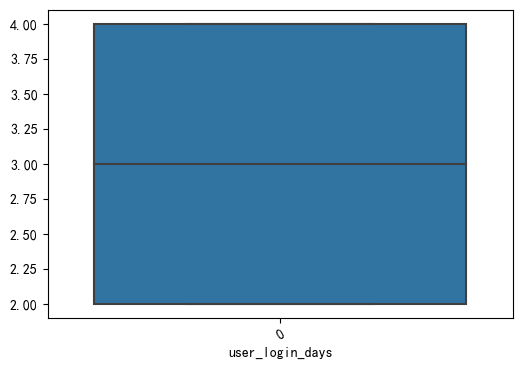

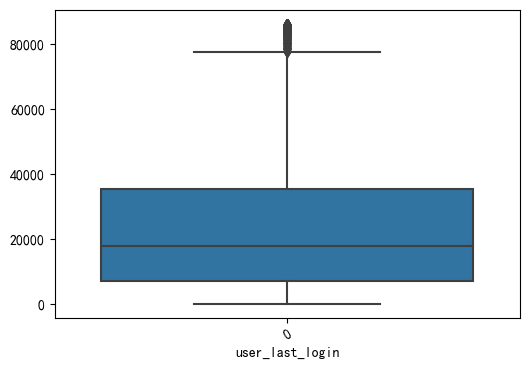

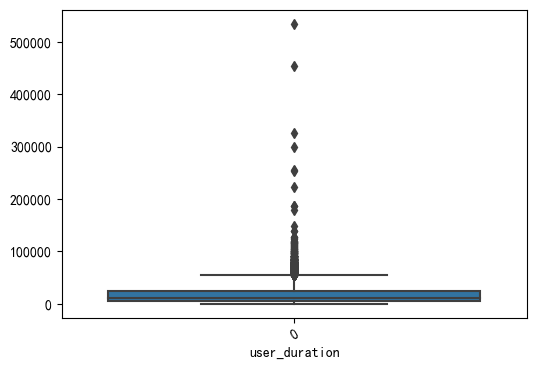

In [582]:
for col in user_level_df.columns:
    if col == 'user_id': 
        continue
    plt.subplots(figsize=(6, 4))
    plt.rcParams['axes.unicode_minus'] = False
    plt.xticks(rotation=30)      
    sns.boxplot(data=user_level_df[col].values)   
    plt.xlabel(col)

In [583]:
# 箱型图处理异常点
def box_outlier(data):
    df = data.copy()
    for col in df.columns:                  # 对每一列分别用箱型图进行判断
        if col in {'user_id','level_id'}:
            continue
        Q1 = df[col].quantile(q=0.25)       # 下四分位
        Q3 = df[col].quantile(q=0.75)       # 上四分位
        low_whisker = Q1 - 3 * (Q3 - Q1)    # 下边缘
        up_whisker = Q3 + 3 * (Q3 - Q1)     # 上边缘
        
        # 寻找异常点,用上下边缘重置
        rule_low =(df[col] < low_whisker)  
        rule_up = (df[col] > up_whisker) 
        df[col].loc[rule_low]=low_whisker
        df[col].loc[rule_up]=up_whisker
    return df

train_df_view1 = train_df.merge(user_level_df , on='user_id', how='left')
train_x = train_df_view1.drop(columns=['label','user_id'])
train_x = box_outlier(train_x).values                                           # 训练集特征
train_y =train_df_view1['label'].values                                         # 训练集标签
dev_df_view = dev_df.merge(user_level_df , on='user_id', how='left')
dev_x =  dev_df_view.drop(columns=['label','user_id'])
dev_x = box_outlier(dev_x).values                                               # 验证集特征
dev_y = dev_df_view['label'].values                                             # 验证集特征


test_df_view = test_df.merge(user_level_df , on='user_id', how='left')
test_x =  test_df_view.drop(columns=['user_id'])
test_x = box_outlier(test_x).values                                             # 测试集特征


/tmp/ipykernel_15080/1360097749.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].loc[rule_low]=low_whisker
/tmp/ipykernel_15080/1360097749.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].loc[rule_up]=up_whisker
/tmp/ipykernel_15080/1360097749.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].loc[rule_low]=low_whisker
/tmp/ipykernel_15080/1360097749.py:16: SettingWithCopyWarning: 
A value is trying to

In [584]:
# 数据归一化
scaler = MinMaxScaler()
train_x = np.array(scaler.fit_transform(train_x))
dev_x = np.array(scaler.transform(dev_x))
test_x = np.array(scaler.transform(test_x))

## 六、模型及调优

采用决策树、逻辑回归、朴素贝叶斯、K-NN和SVM五个基分类器，分别做模型和调参优化。再把各自的模型加到Bagging和Boosing中去，再调优。

In [585]:
# 记录结果
exec_result = pd.DataFrame(columns=['type','method','auc', 'fpr', 'tpr', 'accuracy','parameters'])

### 6.1 决策树

使用决策树在验证集上调优。

In [586]:
for max_depth in range(2, 8):                                                                    
    for criterion in ['entropy']:
        for min_samples_split in range(10, 300, 50):
            clf = DecisionTreeClassifier(max_depth=max_depth, criterion = criterion, max_features=1.0, min_samples_split=min_samples_split)
            clf.fit(train_x, train_y)
            y_predict = clf.predict_proba(dev_x)[:, 1]
            fpr_tree,tpr_tree,thresholds=roc_curve(dev_y, y_predict)                               # 计算fpr、tpr的值
            auc_tree = roc_auc_score(dev_y, y_predict)                                             # 计算auc的值
            accuracy_tree = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))             # 计算accuracy的值
            exec_result.loc[exec_result.shape[0]] = ['base', 'dtree', auc_tree, fpr_tree, tpr_tree, accuracy_tree, 'max_depth:' + str(max_depth) + '; criterion:' + criterion + '; min_samples_split:' + str(min_samples_split)]
            
best_index = exec_result.query("type=='base' & method=='dtree'")['auc'].idxmax()
auc_tree_best= exec_result.loc[best_index]
auc_tree_best.auc,auc_tree_best.parameters

(0.7914648682896447, 'max_depth:5; criterion:entropy; min_samples_split:260')

再使用决策树+Bagging继续调优。

In [587]:
clf = DecisionTreeClassifier(max_depth=5, criterion='entropy', max_features=1.0, min_samples_split=260,random_state=0)
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正

for n_estimator in range(3, 20, 1) : 
    bclf = BaggingClassifier(base_estimator=clf,n_estimators=n_estimator, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=0)
    bclf.fit(train_x, train_y)
    y_predict = bclf.predict_proba(dev_x)[:, 1]
    fpr_tree,tpr_tree,thresholds=roc_curve(dev_y, y_predict)                               # 计算fpr、tpr的值
    auc_tree = roc_auc_score(dev_y, y_predict)                                             # 计算auc的值
    accuracy_tree = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))             # 计算accuracy的值
    exec_result.loc[exec_result.shape[0]] = ['bagging', 'dtree', auc_tree, fpr_tree, tpr_tree, accuracy_tree, 'n_estimator:' + str(n_estimator) ]       #+ '; max_feature:' + str(max_feature)
          
best_index = exec_result.query("type=='bagging' & method=='dtree'")['auc'].idxmax()
auc_tree_bagging_best= exec_result.loc[best_index]
auc_tree_bagging_best.auc,auc_tree_bagging_best.parameters

(0.797597622827226, 'n_estimator:10')

进一步使用随机森林对比。

In [588]:
for n_estimator in range(2, 10, 1):                                                                 
    for max_feature in [10]:                      #range(7, 11, 1):
        rfclf = RandomForestClassifier(n_estimators=n_estimator,bootstrap=True, max_depth=5, max_features=max_feature/10, criterion='entropy',min_samples_split=260,random_state=0)  #max_feature/10
        rfclf.fit(train_x, train_y.flatten())
        y_predict = rfclf.predict_proba(dev_x)[:, 1]
        fpr_tree,tpr_tree,thresholds=roc_curve(dev_y, y_predict)                               # 计算fpr、tpr的值
        auc_tree = roc_auc_score(dev_y, y_predict)                                             # 计算auc的值
        accuracy_tree = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))             # 计算accuracy的值
        exec_result.loc[exec_result.shape[0]] = ['random_forest', 'dtree', auc_tree, fpr_tree, tpr_tree, accuracy_tree, 'n_estimator:' + str(n_estimator) + ';max_features:' + str(max_feature/10)]
            
best_index = exec_result.query("type=='random_forest' & method=='dtree'")['auc'].idxmax()
auc_tree_random_forest_best= exec_result.loc[best_index]
auc_tree_random_forest_best.auc,auc_tree_random_forest_best.parameters

(0.7967189431587113, 'n_estimator:8;max_features:1.0')

决策树+AdaBoost实现如下：

In [589]:
clf = DecisionTreeClassifier(max_depth=5, criterion='entropy', max_features=1.0, min_samples_split=260,random_state=0)
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正

bclf = AdaBoostClassifier(base_estimator=clf,n_estimators=20,random_state=0)
bclf.fit(train_x, train_y)
y_predict = bclf.predict_proba(dev_x)[:, 1]
fpr_boosting_dtree,tpr_boosting_dtree,thresholds=roc_curve(dev_y, y_predict)                     # 计算fpr、tpr的值
auc_boosting_dtree = roc_auc_score(dev_y, y_predict)                                             # 计算auc的值
accuracy_boosting_dtree = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))             # 计算accuracy的值

exec_result.loc[exec_result.shape[0]] = ['boosting', 'dtree', auc_boosting_dtree, fpr_boosting_dtree, tpr_boosting_dtree, accuracy_boosting_dtree, '']
auc_boosting_dtree


0.7936903093192476

### 6.2回归分析

使用逻辑回归在验证集上对二分类调优。

In [591]:
clf = LogisticRegression(n_jobs=-1)
clf.fit(train_x, train_y)
y_predict = clf.predict_proba(dev_x)[:, 1]
fpr_regression,tpr_regression,thresholds=roc_curve(dev_y, y_predict)                         # 计算fpr、tpr的值
auc_regression = roc_auc_score(dev_y, y_predict)                                             # 计算auc的值
accuracy_regression = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))             # 计算accuracy的值
exec_result.loc[exec_result.shape[0]] = ['base', 'logic_regression', auc_regression, fpr_regression, tpr_regression, accuracy_regression, '']
            
best_index = exec_result.query("type=='base' & method=='logic_regression'")['auc'].idxmax()
auc_regression_best= exec_result.loc[best_index]
auc_regression_best.auc

0.7926170693790558

再使用逻辑回归+Bagging对比。

In [592]:
np.random.seed(0)
clf = LogisticRegression(n_jobs=-1)
# clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正

for n_estimator in range(6, 20, 1):   
    bclf = BaggingClassifier(base_estimator=clf,n_estimators=n_estimator, max_samples=0.8, bootstrap=True, n_jobs=-1)
    bclf.fit(train_x, train_y)
    y_predict = bclf.predict_proba(dev_x)[:, 1]
    fpr_regression,tpr_regression,thresholds=roc_curve(dev_y, y_predict)                         # 计算fpr、tpr的值
    auc_regression = roc_auc_score(dev_y, y_predict)                                             # 计算auc的值
    accuracy_regression = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))             # 计算accuracy的值
    exec_result.loc[exec_result.shape[0]] = ['bagging', 'logic_regression', auc_regression, fpr_regression, tpr_regression, accuracy_regression, 'n_estimator:' + str(n_estimator) ]       #+ '; max_feature:' + str(max_feature)
            
best_index = exec_result.query("type=='bagging' & method=='logic_regression'")['auc'].idxmax()
auc_regression_bagging_best= exec_result.loc[best_index]
auc_regression_bagging_best.auc,auc_regression_bagging_best.parameters

(0.7932247543834492, 'n_estimator:16')

逻辑回归+AdaBoost模型如下：

In [593]:
np.random.seed(0)
clf = LogisticRegression(n_jobs=-1)

bclf = AdaBoostClassifier(base_estimator=clf,n_estimators=50,random_state=0)
bclf.fit(train_x, train_y)
y_predict = bclf.predict_proba(dev_x)[:, 1]
fpr_boosting_regression,tpr_boosting_regression,thresholds=roc_curve(dev_y, y_predict)                               # 计算fpr、tpr的值
auc_boosting_regression = roc_auc_score(dev_y, y_predict)                                             # 计算auc的值
accuracy_boosting_regression = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))             # 计算accuracy的值

exec_result.loc[exec_result.shape[0]] = ['boosting', 'logic_regression', accuracy_boosting_regression, fpr_boosting_regression, tpr_boosting_regression, accuracy_boosting_regression, '']
auc_boosting_regression

0.789511053613357

### 6.3朴素贝叶斯

使用朴素贝叶斯在验证集上对二分类调优。

In [632]:
for a in range(1,100):
    clf = ComplementNB(alpha=a/100)
    clf.fit(train_x, train_y)
    y_predict = clf.predict_proba(dev_x)[:,1]
    fpr_nb,tpr_nb,thresholds=roc_curve(dev_y, y_predict)                                   # 计算fpr、tpr的值
    auc_nb = roc_auc_score(dev_y, y_predict)                                               # 计算auc的值
    accuracy_nb = accuracy_score(dev_y,np.around(y_predict, 0).astype(int))                # 计算accuracy的值
    exec_result.loc[exec_result.shape[0]] = ['base', 'nb', auc_nb, fpr_nb, tpr_nb, accuracy_nb, 'alpha:' + str(a/100)]
    
best_index = exec_result.query("type=='base' & method=='nb'")['auc'].idxmax()
auc_nb_best= exec_result.loc[best_index]
auc_nb_best

auc_nb_best.auc,auc_nb_best.parameters

(0.7899595529409238, 'alpha:0.85')

再使用朴素贝叶斯+Bagging对比。

In [635]:
np.random.seed(0)
clf =ComplementNB(alpha=0.85)
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正

for n_estimator in range(6, 10, 1):   
    bclf = BaggingClassifier(base_estimator=clf,n_estimators=n_estimator, max_samples=0.8, bootstrap=True, n_jobs=-1)
    bclf.fit(train_x, train_y)
    y_predict = bclf.predict_proba(dev_x)[:, 1]
    fpr_bagging_nb,tpr_bagging_nb,thresholds=roc_curve(dev_y, y_predict)                       # 计算fpr、tpr的值
    auc_bagging_nb = roc_auc_score(dev_y, y_predict)                                           # 计算auc的值 auc(fpr_bagging_nb, tpr_bagging_nb)
    accuracy_bagging_nb = accuracy_score(dev_y,  np.around(y_predict, 0).astype(int))          # 计算accuracy的值
    exec_result.loc[exec_result.shape[0]] = ['bagging', 'nb', auc_bagging_nb, fpr_bagging_nb, tpr_bagging_nb, accuracy_bagging_nb, 'n_estimators:' + str(n_estimator) ]
best_index = exec_result.query("type=='bagging' & method=='nb'")['auc'].idxmax()
auc_bagging_nb_best= exec_result.loc[best_index]
auc_bagging_nb_best.auc, auc_bagging_nb_best.parameters

(0.7903669924708966, 'n_estimators:9')

朴素贝叶斯+AdaBoost模型如下：

In [636]:
clf =ComplementNB(alpha=0.85)
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正
bclf = AdaBoostClassifier(base_estimator=clf,n_estimators=20,random_state=0)
bclf.fit(train_x, train_y)
y_predict = bclf.predict_proba(dev_x)[:, 1]
fpr_boosting_nb,tpr_boosting_nb,thresholds=roc_curve(dev_y, y_predict)                         # 计算fpr、tpr的值
auc_boosting_nb = roc_auc_score(dev_y, y_predict)                                              # 计算auc的值 auc(fpr_boosting_nb, tpr_boosting_nb)
accuracy_boosting_nb = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))              # 计算accuracy的值

exec_result.loc[exec_result.shape[0]] = ['boosting', 'nb', auc_boosting_nb, fpr_boosting_nb, tpr_boosting_nb, accuracy_boosting_nb, '']
auc_boosting_nb 

0.7946012051366438

### 6.4K-NN

使用K-NN在验证集上对二分类调优。

In [626]:

for k in [1,90]:   
    for w in ['uniform', 'distance']:
        clf = KNeighborsClassifier(n_neighbors=k, weights=w, algorithm='auto', n_jobs=-1,p=2)
        clf.fit(train_x, train_y)
        y_predict = clf.predict_proba(dev_x)[:,1]
        fpr_knn,tpr_knn,thresholds=roc_curve(dev_y, y_predict)                             # 计算fpr、tpr的值
        auc_knn = roc_auc_score(dev_y, y_predict)                                          # 计算auc的值
        accuracy_knn = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))          # 计算accuracy的值
        exec_result.loc[exec_result.shape[0]] = ['base', 'knn', auc_knn, fpr_knn, tpr_knn, accuracy_knn, 'n_neighbors:' + str(k) + '; weights:' + w]
            
best_index = exec_result.query("type=='base' & method=='knn'")['auc'].idxmax()
auc_knn_best= exec_result.loc[best_index]
auc_knn_best.auc,auc_knn_best.parameters

(0.790549550647892, 'n_neighbors:90; weights:distance')

再使用K-NN+Bagging对比。

In [629]:
np.random.seed(0)
clf = KNeighborsClassifier(n_neighbors=90, weights='distance')
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正

for n in [6,8,10]:     
    for max_feature in [8,10]:
        bclf = BaggingClassifier(base_estimator=clf,n_estimators=n_estimator, max_samples=1.0, 
                    max_features=max_feature/10, bootstrap=True,n_jobs=-1, random_state=0)
        bclf.fit(train_x, train_y)
        y_predict = bclf.predict_proba(dev_x)[:, 1]
        fpr_bagging_knn,tpr_bagging_knn,thresholds=roc_curve(dev_y, y_predict)                     # 计算fpr、tpr的值
        auc_bagging_knn = roc_auc_score(dev_y, y_predict)                                          # 计算auc的值 auc(fpr_bagging_knn, tpr_bagging_knn)
        accuracy_bagging_knn = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))          # 计算accuracy的值
        exec_result.loc[exec_result.shape[0]] = ['bagging', 'knn', auc_bagging_knn, fpr_bagging_knn, tpr_bagging_knn, accuracy_bagging_knn, 'n_estimators:' + str(n)]
best_index = exec_result.query("type=='bagging' & method=='knn'")['auc'].idxmax()
auc_bagging_knn_best= exec_result.loc[best_index]
auc_bagging_knn_best.auc, auc_bagging_knn_best.parameters

/home/shaw/anaconda3/lib/python3.9/site-packages/sklearn/calibration.py:310: UserWarning: Since KNeighborsClassifier does not appear to accept sample_weight, sample weights will only be used for the calibration itself. This can be caused by a limitation of the current scikit-learn API. See the following issue for more details: https://github.com/scikit-learn/scikit-learn/issues/21134. Be warned that the result of the calibration is likely to be incorrect.
  warnings.warn(
/home/shaw/anaconda3/lib/python3.9/site-packages/sklearn/calibration.py:310: UserWarning: Since KNeighborsClassifier does not appear to accept sample_weight, sample weights will only be used for the calibration itself. This can be caused by a limitation of the current scikit-learn API. See the following issue for more details: https://github.com/scikit-learn/scikit-learn/issues/21134. Be warned that the result of the calibration is likely to be incorrect.
  warnings.warn(
/home/shaw/anaconda3/lib/python3.9/site-packag

(0.794054162294851, 'n_estimators:6')

K-NN+AdaBoost模型如下：

In [630]:
clf = KNeighborsClassifier(n_neighbors=90, weights='distance', algorithm='auto', n_jobs=-1,p=2)
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正

bclf = AdaBoostClassifier(base_estimator=clf,n_estimators=20,random_state=0)
bclf.fit(train_x, train_y)
y_predict = bclf.predict_proba(dev_x)[:, 1]
fpr_boosting_knn,tpr_boosting_knn,thresholds=roc_curve(dev_y, y_predict)                           # 计算fpr、tpr的值
auc_boosting_knn =  roc_auc_score(dev_y, y_predict)                                                # 计算auc的值 auc(fpr_boosting_knn, tpr_boosting_knn)
accuracy_boosting_knn = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))                 # 计算accuracy的值

exec_result.loc[exec_result.shape[0]] = ['boosting', 'knn', auc_boosting_knn, fpr_boosting_knn, tpr_boosting_knn, accuracy_boosting_knn, '']
auc_boosting_knn

/home/shaw/anaconda3/lib/python3.9/site-packages/sklearn/calibration.py:310: UserWarning: Since KNeighborsClassifier does not appear to accept sample_weight, sample weights will only be used for the calibration itself. This can be caused by a limitation of the current scikit-learn API. See the following issue for more details: https://github.com/scikit-learn/scikit-learn/issues/21134. Be warned that the result of the calibration is likely to be incorrect.
  warnings.warn(
/home/shaw/anaconda3/lib/python3.9/site-packages/sklearn/calibration.py:310: UserWarning: Since KNeighborsClassifier does not appear to accept sample_weight, sample weights will only be used for the calibration itself. This can be caused by a limitation of the current scikit-learn API. See the following issue for more details: https://github.com/scikit-learn/scikit-learn/issues/21134. Be warned that the result of the calibration is likely to be incorrect.
  warnings.warn(
/home/shaw/anaconda3/lib/python3.9/site-packag

0.7916076300474334

### 6.5支持向量机

使用支持向量机在验证集上对二分类调优。

In [615]:
for c in range(1,20):
    clf = LinearSVC(C=c, dual=False)
    clf.fit(train_x, train_y)
    y_predict = clf._predict_proba_lr(dev_x)[:,1]
    fpr_svm,tpr_svm,thresholds=roc_curve(dev_y, y_predict)                                 # 计算fpr、tpr的值
    auc_svm = roc_auc_score(dev_y, y_predict)                                              # 计算auc的值
    accuracy_svm = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))              # 计算accuracy的值
    exec_result.loc[exec_result.shape[0]] = ['base', 'svm', auc_svm, fpr_svm, tpr_svm, accuracy_svm, 'C:' + str(c)]
    # print(auc_svm, 'C:' + str(c))
            
best_index = exec_result.query("type=='base' & method=='svm'")['auc'].idxmax()
auc_svm_best= exec_result.loc[best_index]
auc_svm_best.auc,auc_svm_best.parameters

(0.7930409328280661, 'C:1')

再使用支持向量机+Bagging对比。

In [638]:
clf =  LinearSVC(C=1,dual=False)
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正

for n_estimator in range(1, 50, 1):                                                                    
    for max_feature in range(7, 11,1):
        bclf = BaggingClassifier(base_estimator=clf,n_estimators=n_estimator, max_samples=1.0, 
                    max_features=max_feature/10, bootstrap=True,n_jobs=-1, random_state=0)
        bclf.fit(train_x, train_y)
        y_predict = bclf.predict_proba(dev_x)[:, 1]
        fpr_svm,tpr_svm,thresholds=roc_curve(dev_y, y_predict)                                  # 计算fpr、tpr的值
        auc_svm = roc_auc_score(dev_y, y_predict)                                               # 计算auc的值
        accuracy_svm = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))               # 计算accuracy的值
        exec_result.loc[exec_result.shape[0]] = ['bagging', 'svm', auc_svm, fpr_svm, tpr_svm, accuracy_svm, 'n_estimator:' + str(n_estimator) + '; max_feature:' + str(max_feature)]
            
best_index = exec_result.query("type=='bagging' & method=='svm'")['auc'].idxmax()
auc_svm_bagging_best= exec_result.loc[best_index]
auc_svm_bagging_best.auc,auc_svm_bagging_best.parameters

(0.7933403535059067, 'n_estimator:3; max_feature:10')

支持向量机+AdaBoost模型如下：

In [637]:
clf =  LinearSVC(C=1, dual=False)     #  loss='squared_hinge'
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')   # 概率校正

bclf = AdaBoostClassifier(base_estimator=clf,n_estimators=50,random_state=0)
bclf.fit(train_x, train_y)
y_predict = bclf.predict_proba(dev_x)[:, 1]
fpr_boosting_svm,tpr_boosting_svm,thresholds=roc_curve(dev_y, y_predict)                       # 计算fpr、tpr的值
auc_boosting_svm = roc_auc_score(dev_y, y_predict)                                             # 计算auc的值
accuracy_boosting_svm = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))             # 计算accuracy的值

exec_result.loc[exec_result.shape[0]] = ['boosting', 'svm', auc_boosting_svm, fpr_boosting_svm, tpr_boosting_svm, accuracy_boosting_svm, '']
auc_boosting_svm

0.789090980299509

### 6.6 加权多数投票

In [640]:
voting_clf = VotingClassifier(estimators=[
    ('DecisionTree', DecisionTreeClassifier(max_depth=5, criterion='entropy', max_features=1.0, min_samples_split=10,random_state=0)),
    ('LogisticRegression', LogisticRegression()),
    ('BernoulliNB', BernoulliNB(alpha=0.01)),
    # ('ComplementNB', ComplementNB()),
    # ('GaussianNB', GaussianNB()),
    ('MultinomialNB', MultinomialNB(alpha=1, fit_prior=True)),
    ('KNN', KNeighborsClassifier(n_neighbors=9, weights='uniform', algorithm='auto', n_jobs=-1,p=1)),
    ('LinearSVM', CalibratedClassifierCV(LinearSVC(C=1,loss='squared_hinge', dual=False), cv=2, method='sigmoid'))
], voting='soft') #hard

voting_clf.fit(train_x, train_y)
y_predict = voting_clf.predict_proba(dev_x)[:, 1]
fpr_voting__svm,tpr_voting__svm,thresholds=roc_curve(dev_y, y_predict)                        # 计算fpr、tpr的值
auc_voting__svm = roc_auc_score(dev_y, y_predict)                                             # 计算auc的值
accuracy_voting__svm = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))             # 计算accuracy的值

exec_result.loc[exec_result.shape[0]] = ['voting', 'all', auc_voting__svm, fpr_voting__svm, tpr_voting__svm, accuracy_voting__svm, '']
auc_voting__svm



0.793399100600926

## 七、小结

### 7.1AUC对比

In [641]:
exec_result.groupby(['type','method'])['auc'].max().reset_index().sort_values(['auc'])

,type,method,auc
12,boosting,logic_regression,0.740406
14,boosting,svm,0.789091
8,base,nb,0.789960
3,bagging,nb,0.790367
6,base,knn,0.790550
5,base,dtree,0.791465
11,boosting,knn,0.791608
7,base,logic_regression,0.792617
9,base,svm,0.793041
2,bagging,logic_regression,0.793225


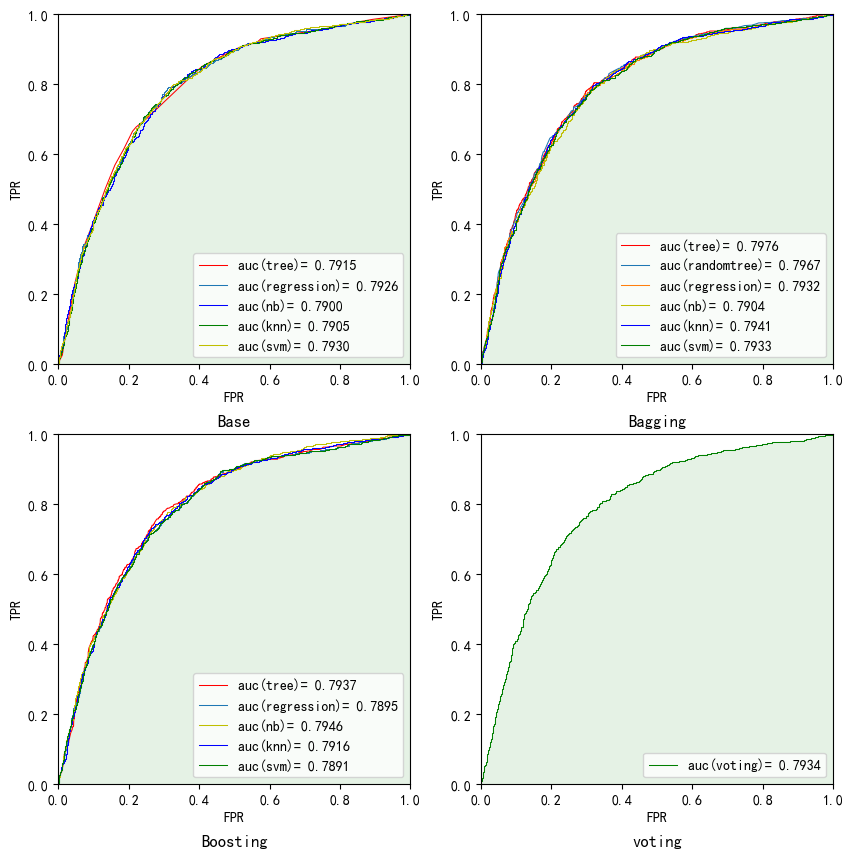

In [642]:
plt.figure(figsize=(10,10), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
ax_base = plt.subplot(221)
ax_base.fill_between(auc_knn_best.fpr, auc_knn_best.tpr,y2=0, facecolor='g', alpha=0.1)
ax_base.plot(auc_tree_best.fpr, auc_tree_best.tpr, color='r',lw=0.75,label='auc(tree)= %0.4f' % auc_tree_best.auc)
ax_base.plot(auc_regression_best.fpr, auc_regression_best.tpr, lw=0.75,label='auc(regression)= %0.4f' % auc_regression_best.auc)  
ax_base.plot(auc_nb_best.fpr, auc_nb_best.tpr, color='b',lw=0.75,label='auc(nb)= %0.4f' % auc_nb_best.auc)         
ax_base.plot(auc_knn_best.fpr, auc_knn_best.tpr, color='g',lw=0.75,label='auc(knn)= %0.4f' % auc_knn_best.auc)     
ax_base.plot(auc_svm_best.fpr, auc_svm_best.tpr, color='y',lw=0.75,label='auc(svm)= %0.4f' % auc_svm_best.auc)     
ax_base.set_xlim([0.0, 1.0])
ax_base.set_ylim([0.0, 1.0])
ax_base.set_xlabel('FPR')
ax_base.set_ylabel('TPR')
ax_base.set_title('Base',fontsize=12,fontweight='bold', y=-0.2)
ax_base.legend()

ax_bagging = plt.subplot(222)
# ax_bagging.fill_between(auc_bagging_tree_best.fpr, auc_bagging_tree_best.tpr,y2=0, facecolor='r', alpha=0.1)
# ax_bagging.fill_between(auc_bagging_nb_best.fpr, auc_bagging_nb_best.tpr,y2=0, facecolor='y', alpha=0.1)
# ax_bagging.fill_between(auc_bagging_knn_best.fpr, auc_bagging_knn_best.tpr,y2=0, facecolor='b', alpha=0.4)
ax_bagging.fill_between(auc_svm_bagging_best.fpr, auc_svm_bagging_best.tpr,y2=0, facecolor='g', alpha=0.1)
ax_bagging.plot(auc_tree_bagging_best.fpr, auc_tree_bagging_best.tpr, color='r',lw=0.75,label='auc(tree)= %0.4f' % auc_tree_bagging_best.auc)  
ax_bagging.plot(auc_tree_random_forest_best.fpr, auc_tree_random_forest_best.tpr,lw=0.75,label='auc(randomtree)= %0.4f' % auc_tree_random_forest_best.auc)  
ax_bagging.plot(auc_regression_bagging_best.fpr, auc_regression_bagging_best.tpr,lw=0.75,label='auc(regression)= %0.4f' % auc_regression_bagging_best.auc)    
ax_bagging.plot(auc_bagging_nb_best.fpr, auc_bagging_nb_best.tpr, color='y',lw=0.75,label='auc(nb)= %0.4f' % auc_bagging_nb_best.auc)         
ax_bagging.plot(auc_bagging_knn_best.fpr, auc_bagging_knn_best.tpr, color='b',lw=0.75,label='auc(knn)= %0.4f' % auc_bagging_knn_best.auc)     
ax_bagging.plot(auc_svm_bagging_best.fpr, auc_svm_bagging_best.tpr, color='g',lw=0.75,label='auc(svm)= %0.4f' % auc_svm_bagging_best.auc)      
ax_bagging.set_xlim([0.0, 1.0])
ax_bagging.set_ylim([0.0, 1.0])
ax_bagging.set_xlabel('FPR')
ax_bagging.set_ylabel('TPR')
ax_bagging.set_title('Bagging',fontsize=12,fontweight='bold', y=-0.2)
ax_bagging.legend()

ax_boosting = plt.subplot(223)
# ax_boosting.fill_between(fpr_boosting_tree, tpr_boosting_tree, y2=0, facecolor='g', alpha=0.2)
# ax_boosting.fill_between(fpr_boosting_nb, tpr_boosting_nb,y2=0, facecolor='y', alpha=0.1)
# ax_boosting.fill_between(fpr_boosting_knn, tpr_boosting_knn,y2=0, facecolor='b', alpha=0.4)
ax_boosting.fill_between(fpr_boosting_svm, tpr_boosting_svm,y2=0, facecolor='g', alpha=0.1)
ax_boosting.plot(fpr_boosting_dtree, tpr_boosting_dtree, color='r',lw=0.75,label='auc(tree)= %0.4f' % auc_boosting_dtree) 
ax_boosting.plot(fpr_boosting_regression, tpr_boosting_regression,lw=0.75,label='auc(regression)= %0.4f' % auc_boosting_regression)   
ax_boosting.plot(fpr_boosting_nb, tpr_boosting_nb, color='y',lw=0.75,label='auc(nb)= %0.4f' % auc_boosting_nb)        
ax_boosting.plot(fpr_boosting_knn, tpr_boosting_knn, color='b',lw=0.75,label='auc(knn)= %0.4f' % auc_boosting_knn)     
ax_boosting.plot(fpr_boosting_svm, tpr_boosting_svm, color='g',lw=0.75,label='auc(svm)= %0.4f' % auc_boosting_svm )      
ax_boosting.set_xlim([0.0, 1.0])
ax_boosting.set_ylim([0.0, 1.0])
ax_boosting.set_xlabel('FPR')
ax_boosting.set_ylabel('TPR')
ax_boosting.set_title('Boosting',fontsize=12,fontweight='bold', y=-0.2)
ax_boosting.legend()


ax_boosting = plt.subplot(224)
# ax_boosting.fill_between(fpr_boosting_tree, tpr_boosting_tree, y2=0, facecolor='g', alpha=0.2)
# ax_boosting.fill_between(fpr_boosting_nb, tpr_boosting_nb,y2=0, facecolor='y', alpha=0.1)
# ax_boosting.fill_between(fpr_boosting_knn, tpr_boosting_knn,y2=0, facecolor='b', alpha=0.4)
ax_boosting.fill_between(fpr_voting__svm, tpr_voting__svm,y2=0, facecolor='g', alpha=0.1)  
ax_boosting.plot(fpr_voting__svm, tpr_voting__svm, color='g',lw=0.75,label='auc(voting)= %0.4f' % auc_voting__svm )      
ax_boosting.set_xlim([0.0, 1.0])
ax_boosting.set_ylim([0.0, 1.0])
ax_boosting.set_xlabel('FPR')
ax_boosting.set_ylabel('TPR')
ax_boosting.set_title('voting',fontsize=12,fontweight='bold', y=-0.2)
ax_boosting.legend()

结果为“决策树+Bagging”最好，输入测试集预测文件：

In [607]:

clf = DecisionTreeClassifier(max_depth=5, criterion='entropy', max_features=1.0, min_samples_split=260,random_state=0)
clf = CalibratedClassifierCV(clf, cv=2, method='sigmoid')  # 概率校正

bclf = BaggingClassifier(base_estimator=clf,n_estimators=10, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=0)
bclf.fit(train_x, train_y)
y_predict = bclf.predict_proba(dev_x)[:, 1]
fpr_tree,tpr_tree,thresholds=roc_curve(dev_y, y_predict)                               # 计算fpr、tpr的值
auc_tree = roc_auc_score(dev_y, y_predict)                                             # 计算auc的值
accuracy_tree = accuracy_score(dev_y, np.around(y_predict, 0).astype(int))             # 计算accuracy的值
print(auc_tree)

# 测试集预测
shaw_result = pd.DataFrame(columns=['ID','Prediction'])
shaw_result['ID'] =test_df['user_id']
shaw_result['Prediction'] =[x[1] for x in bclf.predict_proba(test_x)]
shaw_result =shaw_result.groupby('ID')['Prediction'].max().reset_index() 
shaw_result.to_csv('./data/shaw_result.csv',index=False)

0.797597622827226


### 7.2 关于特征的思考

基于模型回头看特征的重要性，通过模型训红利到相应的重要性权重。如下图所示：

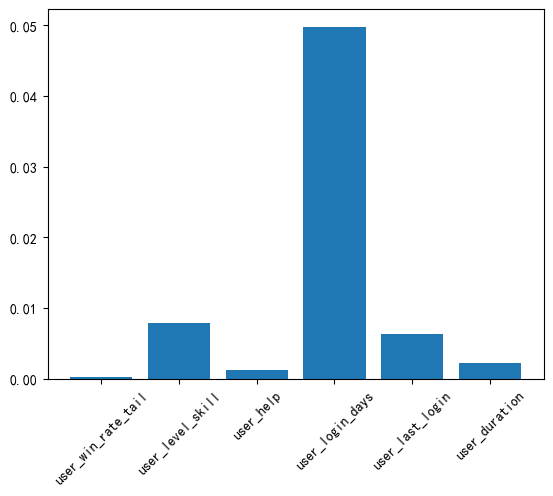

In [656]:
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(train_x, train_y)
r= permutation_importance(model, dev_x, dev_y, scoring='neg_mean_squared_error', n_repeats=30, random_state=0)
plt.bar(['user_win_rate_tail','user_level_skill','user_help','user_login_days','user_last_login','user_duration'], r.importances_mean)
plt.xticks(rotation=45)
plt.show()

越重要的特征，对于业务中如何提升留存用户越重要。
* 用户每天都登录的流失概率更低，那么可以提高“签到”之类的活动收益；活动收益可以按天等比提高。
* 结合前面“数据观测”高技玩家流失性，是否可以考虑同一关卡分成难易程度不同的级别，以提高部分商技玩家的可玩性。
* 用户帮助和道具的使用，对新玩家一样是不可或缺的部分。但也有部分用户从来没使用过。如果能改进这点的使用，会对用户的流存和模型产生更积极的影响。